#### *Goal*
Build model to predict taxi trip time given a specific pickup and dropoff location.
We will be using NYC Green Taxi trip records. 

[Data can be found here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [124]:
import pandas as pd
import requests
import io
import sys
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [46]:
sns.set_style("white")

In [47]:
def download_parquet_to_df(year_month, taxi_type="green"):
    url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/{taxi_type}_tripdata_{year_month}.parquet"
    try:
        result = requests.get(url)
    except requests.exceptions.HTTPError as e:
            print("ERROR ".center(90, "-"))
            print(e, file=sys.stderr)
            print("~~> file may not be available on server.")
    except requests.exceptions.RequestException as e:
            print(e, file=sys.stderr)

    return pd.read_parquet(io.BytesIO(result.content))

In [48]:
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2021-01.parquet"

In [49]:
locations = pd.read_csv("ref_zone_lookup.csv",
    dtype={"LocationID": "Int64"}
)

In [50]:
locations.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [51]:
df = download_parquet_to_df(year_month="2021-01", taxi_type="green")

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[ns]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

*Calculate trip time which is our variable of interest*

We will calculate as duration in minutes (min) based on the difference between pickup datetime and dropoff datetime

In [53]:
df["trip_duration"] = (
    (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]) / pd.to_timedelta('1 min')
)

Check the distribution of trip times we just calculated

In [54]:
df["trip_duration"].describe(percentiles=[0.5, 0.85, 0.9, 0.95,0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
85%         30.000000
90%         35.000000
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: trip_duration, dtype: float64

- 98% of trips are under an hour (60 mins). 
- Mean trip time is ~20 mins and the median trip time is ~14 mins

What is going on with trips having duration of 0?

In [55]:
(
    df.query("trip_duration <= 0")
        .merge(
            locations, 
            how="left", 
            left_on="PULocationID", 
            right_on="LocationID")
        .merge(
            locations, 
            how="left", 
            left_on="DOLocationID", 
            right_on="LocationID",
            suffixes=["_PU","_DO"])
        .sort_values(by=["trip_distance"], ascending=False)
).groupby(["LocationID_PU","Borough_PU","LocationID_DO","Borough_DO"])["VendorID"].count().rename("Trips").reset_index().sort_values(by=["Trips"], ascending=False)


,LocationID_PU,Borough_PU,LocationID_DO,Borough_DO,Trips
44,264,Unknown,264,Unknown,14
7,52,Brooklyn,264,Unknown,2
23,145,Queens,264,Unknown,2
1,18,Bronx,18,Bronx,2
16,97,Brooklyn,264,Unknown,2
13,92,Queens,264,Unknown,2
35,215,Queens,130,Queens,2
6,51,Bronx,264,Unknown,2
43,244,Manhattan,264,Unknown,2
39,225,Brooklyn,225,Brooklyn,1


In [56]:
df["trip_type"].value_counts(dropna=False)

1.0    39233
NaN    36047
2.0     1238
Name: trip_type, dtype: int64

In [57]:
(
    df.query("trip_duration == 0")

)[["trip_distance","fare_amount"]].describe(percentiles=[0.85,0.9,0.95,0.99])


,trip_distance,fare_amount
count,66.000000,66.000000
mean,0.006970,12.388939
std,0.024556,13.717669
min,0.000000,0.000000
50%,0.000000,9.000000
85%,0.000000,23.087500
90%,0.005000,27.975000
95%,0.065000,45.250000
99%,0.114000,54.677500
max,0.140000,59.650000


Appears out of these 66 trips most (~85%) have a trip distance of 0. Could it be trips charged for taxi waiting?

In [58]:
df_filtered = df.loc[(df["trip_duration"]>0) & (df["trip_duration"]<=60)]

In [59]:
df_filtered.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'trip_duration'],
      dtype='object')

In [60]:
categorical = ["PULocationID","DOLocationID"]
numerical = ["trip_distance"]

In [61]:
df_filtered[categorical] = df_filtered[categorical].astype(str)

/tmp/ipykernel_94711/4212814509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[categorical] = df_filtered[categorical].astype(str)


In [62]:
train_dicts = df_filtered[categorical + numerical].to_dict(orient="records")

In [63]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [64]:
X_train

<75290x508 sparse matrix of type '<class 'numpy.float64'>'
	with 225870 stored elements in Compressed Sparse Row format>

In [65]:
target = "trip_duration"
y_train = df_filtered[target].values

In [66]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [67]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [68]:
y_pred = lr.predict(X_train)

In [69]:
def prep_dataset(df, categorical, numerical, target):
    print(f"Original data has {df.shape[0]} records.")

    df["trip_duration"] = (
            (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]) / pd.to_timedelta('1 min')
        )

    df = df.loc[(df["trip_duration"]>0) & (df["trip_duration"]<=60)].copy()

    df[categorical] = df[categorical].astype(str)
    df[numerical] = df[numerical].astype(float)

    print(f"Final data has {df.shape[0]} records.")

    return df[categorical + numerical + target]


In [70]:
categorical=["PULocationID","DOLocationID"]
numerical = ["trip_distance"]
target=["trip_duration"]

In [71]:
df_train = prep_dataset(
    df=download_parquet_to_df(year_month="2021-01", taxi_type="green"),
    categorical= categorical,
    numerical = numerical,
    target= target)

Original data has 76518 records.
Final data has 75290 records.


In [72]:
df_val = prep_dataset(
    df=download_parquet_to_df(year_month="2021-02", taxi_type="green"),
    categorical= categorical,
    numerical = numerical,
    target= target)

Original data has 64572 records.
Final data has 62981 records.


In [84]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
val_dicts = df_val[categorical + numerical].to_dict(orient="records")


X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

y_train = df_train[target].values
y_val = df_val[target].values

In [85]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Our model is incorrect on average by {round(mse,2)} minutes")

LinearRegression()

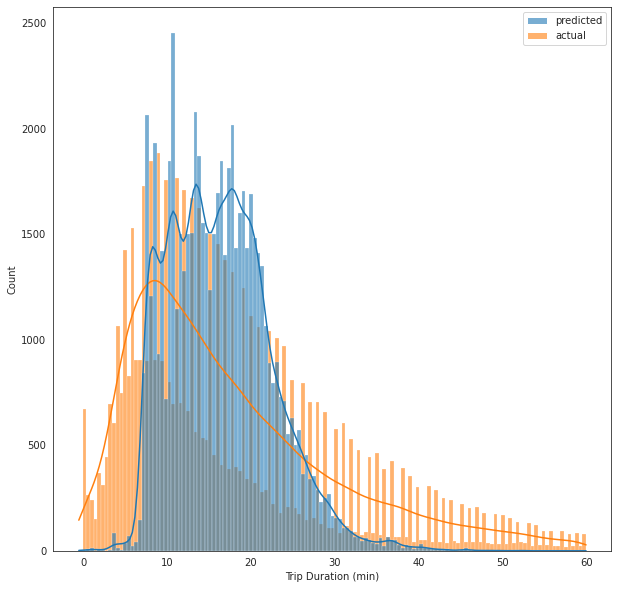

In [87]:

data = {"predicted": y_pred.squeeze(), "actual": y_val.squeeze()}
ax = sns.histplot(data, kde=True, alpha=0.6)
ax.set(xlabel="Trip Duration (min)")
ax.figure.set_size_inches(10, 10)


Lasso

In [96]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Our model is incorrect on average by {round(mse,2)} minutes")

Our model is incorrect on average by 10.57 minutes


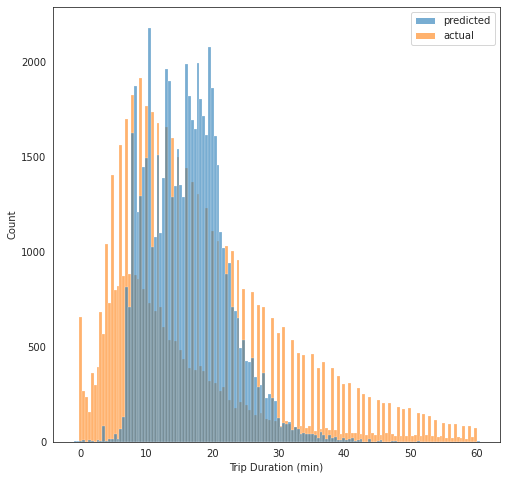

In [97]:
data = {"predicted": y_pred.squeeze(), "actual": y_val.squeeze()}
ax = sns.histplot(data, alpha=0.6)
ax.set(xlabel="Trip Duration (min)")
ax.figure.set_size_inches(8, 8)

In [99]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Our model is incorrect on average by {round(mse,2)} minutes")

Our model is incorrect on average by 10.97 minutes


Getting more creative with our features we train our model with

In [114]:
def prep_dataset(df, categorical, numerical, target):
    print(f"Original data has {df.shape[0]} records.")

    df["trip_duration"] = (
            (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]) / pd.to_timedelta('1 min')
        )

    df["trip_route"] = df["PULocationID"].astype(str) + "_" + df["DOLocationID"].astype(str)
    df["day_of_week"] = df["lpep_pickup_datetime"].dt.day_name()
    df["hour_of_day"] = df["lpep_pickup_datetime"].dt.hour

    df = df.loc[(df["trip_duration"]>0) & (df["trip_duration"]<=60)].copy()

    df[categorical] = df[categorical].astype(str)
    df[numerical] = df[numerical].astype(float)

    print(f"Final data has {df.shape[0]} records.")

    return df[categorical + numerical + target]

In [115]:
categorical=["PULocationID","DOLocationID","trip_route","day_of_week","hour_of_day"]
numerical = ["trip_distance"]
target=["trip_duration"]

In [116]:
df_train = prep_dataset(
    df=download_parquet_to_df(year_month="2021-01", taxi_type="green"),
    categorical= categorical,
    numerical = numerical,
    target= target)

Original data has 76518 records.
Final data has 75290 records.


In [117]:
df_val= prep_dataset(
    df=download_parquet_to_df(year_month="2021-02", taxi_type="green"),
    categorical= categorical,
    numerical = numerical,
    target= target)

Original data has 64572 records.
Final data has 62981 records.


In [118]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
val_dicts = df_val[categorical + numerical].to_dict(orient="records")


X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

y_train = df_train[target].values
y_val = df_val[target].values

In [119]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Our model is incorrect on average by {round(mse,2)} minutes")

Our model is incorrect on average by 7.65 minutes


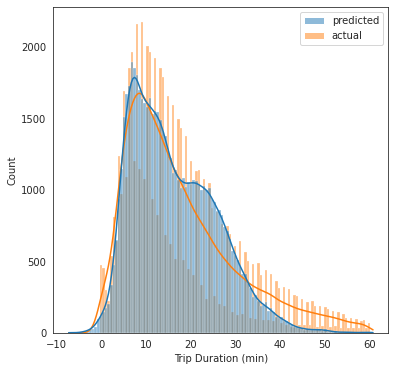

In [122]:
data = {"predicted": y_pred.squeeze(), "actual": y_val.squeeze()}
ax = sns.histplot(data, kde=True, alpha=0.5)
ax.set(xlabel="Trip Duration (min)")
ax.figure.set_size_inches(6, 6)

In [123]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Our model is incorrect on average by {round(mse,2)} minutes")

Our model is incorrect on average by 8.66 minutes


In [125]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Our model is incorrect on average by {round(mse,2)} minutes")

Our model is incorrect on average by 7.65 minutes


Save Linear Regression model to file.

In [126]:
with open("models/linear_regression.bin" , "wb") as f_out:
    pickle.dump((dv, lr), f_out)